In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
from multiprocessing import Pool

In [2]:
data = pd.read_parquet('filled_cu.parquet')
data.dropna(inplace=True)
data

,DateTime,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,...,BidPrice4,BidVolume4,AskPrice4,AskVolume4,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover
1,2023-01-03 09:00:00.500,20230103.0,66240.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99669.0,...,66160.0,160.0,66270.0,2.0,66150.0,353.0,66280.0,1.0,21.0,6952600.0
2,2023-01-03 09:00:01.000,20230103.0,66210.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99682.0,...,66160.0,161.0,66260.0,102.0,66150.0,353.0,66270.0,2.0,56.0,18541250.0
3,2023-01-03 09:00:01.500,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99681.0,...,66200.0,27.0,66270.0,3.0,66170.0,64.0,66280.0,1.0,14.0,4636150.0
4,2023-01-03 09:00:02.000,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99672.0,...,66200.0,28.0,66300.0,56.0,66170.0,63.0,66310.0,1.0,29.0,9603500.0
5,2023-01-03 09:00:02.500,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99671.0,...,66170.0,63.0,66270.0,3.0,66160.0,163.0,66280.0,1.0,18.0,5961050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20787477,2023-12-29 23:59:57.500,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787478,2023-12-29 23:59:58.000,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787479,2023-12-29 23:59:58.500,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787480,2023-12-29 23:59:59.000,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0


In [3]:
data.columns

Index(['DateTime', 'TradingDay', 'LastPrice', 'PreSettlementPrice',
       'PreClosePrice', 'PreOpenInterest', 'OpenPrice', 'HighestPrice',
       'LowestPrice', 'OpenInterest', 'BidPrice1', 'BidVolume1', 'AskPrice1',
       'AskVolume1', 'BidPrice2', 'BidVolume2', 'AskPrice2', 'AskVolume2',
       'BidPrice3', 'BidVolume3', 'AskPrice3', 'AskVolume3', 'BidPrice4',
       'BidVolume4', 'AskPrice4', 'AskVolume4', 'BidPrice5', 'BidVolume5',
       'AskPrice5', 'AskVolume5', 'delta_Volume', 'delta_Turnover'],
      dtype='object')

- 价格均值因子：结合 bid 和 ask 价格求出不同价位的加权平均价格，用来反映市场的整体价格水平。
$$
mid\_price = (BidPrice1 + AskPrice1) / 2
$$
$$
spread = AskPrice1 - BidPrice1
$$

In [4]:
data['vwap'] = data['delta_Turnover']/(data['delta_Volume']*5)
data['vwap'] = data['vwap'].fillna(0)
data['mid_price'] = (data['BidPrice1'] + data['AskPrice1'])/2
data['spread'] = data['AskPrice1'] - data['BidPrice1']
data['label'] = 100*(data['mid_price'].shift(-120)-data['mid_price'])/data['mid_price']
data.dropna(subset='label', inplace=True)
data['TradingDay'] = pd.to_datetime(data['TradingDay'].astype('int'), format='%Y%m%d')
data


,DateTime,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,...,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover,vwap,mid_price,spread,label
1,2023-01-03 09:00:00.500,2023-01-03,66240.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99669.0,...,66150.0,353.0,66280.0,1.0,21.0,6952600.0,66215.238095,66225.0,30.0,-0.045300
2,2023-01-03 09:00:01.000,2023-01-03,66210.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99682.0,...,66150.0,353.0,66270.0,2.0,56.0,18541250.0,66218.750000,66220.0,20.0,-0.030202
3,2023-01-03 09:00:01.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99681.0,...,66170.0,64.0,66280.0,1.0,14.0,4636150.0,66230.714286,66235.0,10.0,-0.045293
4,2023-01-03 09:00:02.000,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99672.0,...,66170.0,63.0,66310.0,1.0,29.0,9603500.0,66231.034483,66245.0,30.0,-0.075477
5,2023-01-03 09:00:02.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99671.0,...,66160.0,163.0,66280.0,1.0,18.0,5961050.0,66233.888889,66225.0,10.0,-0.045300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20787357,2023-12-29 23:58:57.500,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787358,2023-12-29 23:58:58.000,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787359,2023-12-29 23:58:58.500,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787360,2023-12-29 23:58:59.000,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243


In [5]:
def cal_ic(factor):
    daily_ic = data.groupby('TradingDay').apply(lambda x: x[factor].corr(x['label']))
    return daily_ic

## 因子构造

- 买卖盘成交量比率：计算买卖盘成交量的比值，反映市场买卖双方的力量对比。
$$bid\_ask\_volume\_ratio = \frac{BidVolume1 + BidVolume2 + BidVolume3 + BidVolume4 + BidVolume5}{AskVolume1 + AskVolume2 + AskVolume3 + AskVolume4 + AskVolume5}$$

In [6]:
data['bid_ask_volume_ratio'] = (data['BidVolume1']+data['BidVolume2']+data['BidVolume3']+data['BidVolume4']+data['BidVolume5'])/(data['AskVolume1']+data['AskVolume2']+data['AskVolume3']+data['AskVolume4']+data['AskVolume5'])
cal_ic('bid_ask_volume_ratio').mean()

0.02838052397193621

- 持仓量变化率：通过 OpenInterest 计算每分钟持仓量的变化率，反映市场交易活跃程度。
$$open\_interest\_diff = OpenInterest - PreOpenInterest$$

-0.01625887481935536

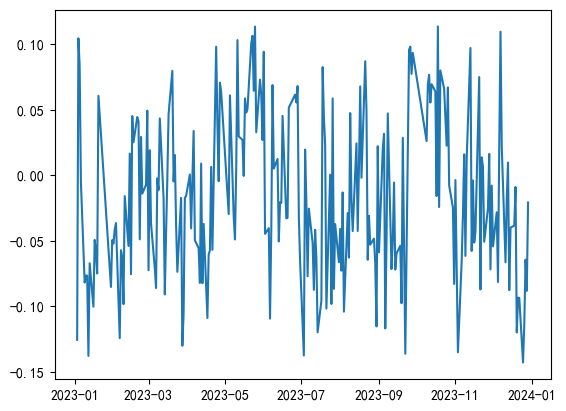

In [7]:
data['open_interest_diff'] = data['OpenInterest'] - data['PreOpenInterest']
plt.plot(cal_ic('open_interest_diff'))
cal_ic('open_interest_diff').mean()

- 相对买卖价差：
$$\text{relative\_spread} = \frac{\text{AskPrice1} - \text{BidPrice1}}{(\text{AskPrice1} + \text{BidPrice1}) / 2}$$

0.0021134720502321534

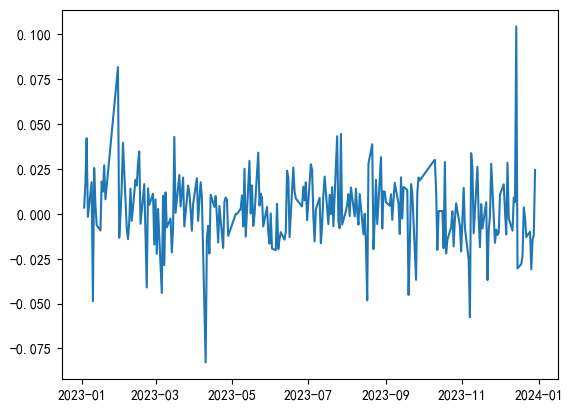

In [8]:
data['relative_spread'] = (data['AskPrice1'] - data['BidPrice1'])/((data['AskPrice1'] + data['BidPrice1'])/2)
plt.plot(cal_ic('relative_spread'))
cal_ic('relative_spread').mean()

- 买盘深度（Bid Depth）：
$$
\text{bid\_depth} = \sum_{i=1}^{N} \text{BidVolume}_i
$$
- 卖盘深度（Ask Depth）：
$$
\text{ask\_depth} = \sum_{i=1}^{N} \text{AskVolume}_i
$$
- 总深度：
$$
\text{total\_depth} = \text{bid\_depth} + \text{ask\_depth}
$$

0.0012112146878057058

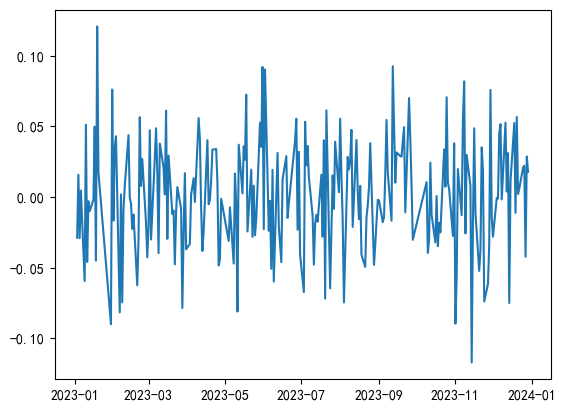

In [9]:
data['bid_depth'] = data['BidVolume1']+data['BidVolume2']+data['BidVolume3']+data['BidVolume4']+data['BidVolume5']
data['ask_depth'] = data['AskVolume1']+data['AskVolume2']+data['AskVolume3']+data['AskVolume4']+data['AskVolume5']
data['total_depth'] = data['bid_depth'] + data['ask_depth'] 
plt.plot(cal_ic('total_depth'))
cal_ic('total_depth').mean()

买卖力量比率衡量了买盘和卖盘之间的力量对比。通过计算买卖盘的订单数量差异，可以判断市场情绪。

- 买卖力量比率：

$$
\text{order\_imbalance} = \frac{\text{bid\_depth} - \text{ask\_depth}}{\text{bid\_depth} + \text{ask\_depth}}
$$

0.030585300440554325

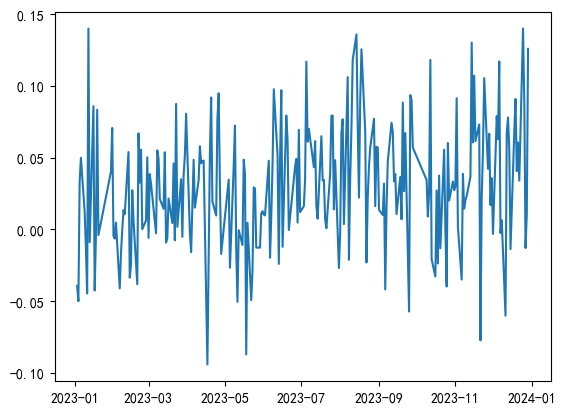

In [10]:
data['order_imbalance'] = (data['bid_depth']-data['ask_depth'])/(data['bid_depth']+data['ask_depth'])
plt.plot(cal_ic('order_imbalance'))
cal_ic('order_imbalance').mean()

1. 移动平均的 Order Imbalance 因子

通过计算过去  n  个时间窗口的 Order Imbalance 移动平均，捕捉买卖不平衡的趋势。移动平均可以平滑因子的短期波动，使其更具稳定性。

$$
\text{OI\_MA}_n = \frac{1}{n} \sum_{i=t-n+1}^{t} \text{Order Imbalance}_{i}
$$


0.02040829691859526

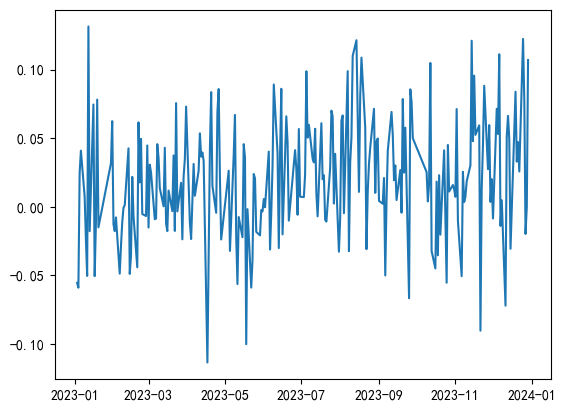

In [11]:
data['OI_MA_10'] = data['order_imbalance'].rolling(window=10).mean()
plt.plot(cal_ic('OI_MA_10'))
cal_ic('OI_MA_10').mean()

0.00896713255087675

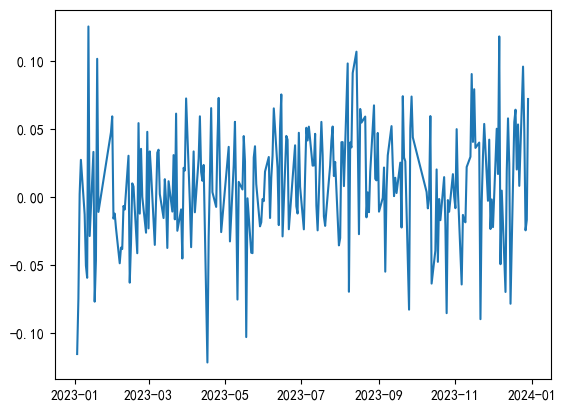

In [12]:
data['OI_MA_120'] = data['order_imbalance'].rolling(window=120).mean()
plt.plot(cal_ic('OI_MA_120'))
cal_ic('OI_MA_120').mean()

Order Imbalance 的变化率因子（Momentum of Order Imbalance）

计算当前 Order Imbalance 相对于过去几个窗口的变化率（动量），用来捕捉不平衡因子的趋势变化。

0.039651914149802

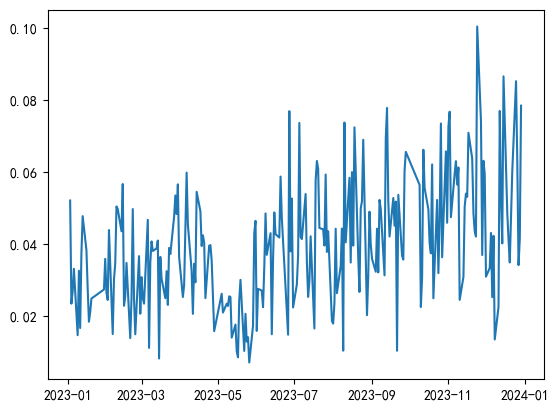

In [13]:
data['OI_momentum_10'] = data['order_imbalance'].diff(10)
plt.plot(cal_ic('OI_momentum_10'))
cal_ic('OI_momentum_10').mean()

0.035163489906948765

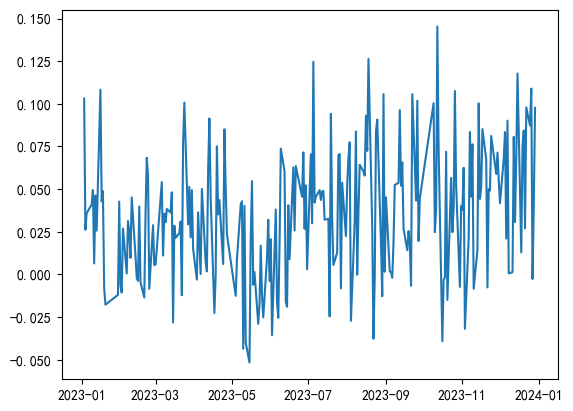

In [14]:
data['OI_momentum_120'] = data['order_imbalance'].diff(120)
plt.plot(cal_ic('OI_momentum_120'))
cal_ic('OI_momentum_120').mean()

计算一段时间内 Order Imbalance 的波动性，捕捉市场买卖力量的不稳定性。较高的波动性意味着市场在这一时段内买卖力量波动较大。

0.0006181791487944519

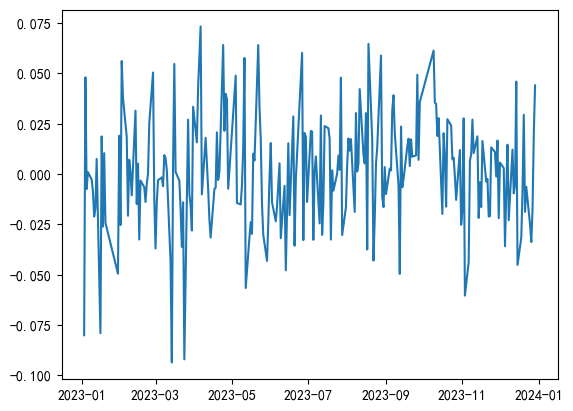

In [15]:
data['OI_std_10'] = data['order_imbalance'].rolling(window=10).std()
plt.plot(cal_ic('OI_std_10'))
cal_ic('OI_std_10').mean()

0.0006461306879640944

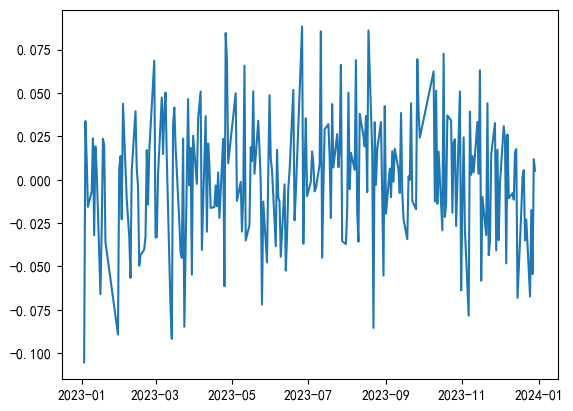

In [16]:
data['OI_std_120'] = data['order_imbalance'].rolling(window=120).std()
plt.plot(cal_ic('OI_std_120'))
cal_ic('OI_std_120').mean()

计算 Order Imbalance 的累积值，反映一段时间内买卖不平衡的累积效应。累积不平衡度可以帮助判断市场长期的买卖倾向。

0.020408296918595286

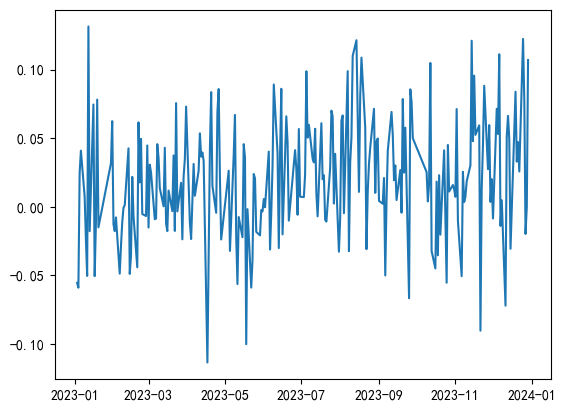

In [17]:
data['OI_cumulative_10'] = data['order_imbalance'].rolling(window=10).sum()
plt.plot(cal_ic('OI_cumulative_10'))
cal_ic('OI_cumulative_10').mean()

0.008967132550876758

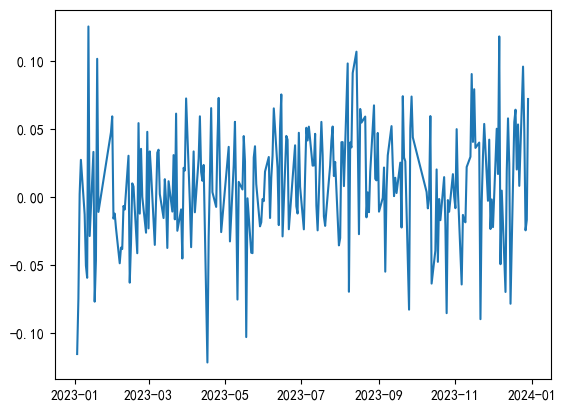

In [18]:
data['OI_cumulative_120'] = data['order_imbalance'].rolling(window=120).sum()
plt.plot(cal_ic('OI_cumulative_120'))
cal_ic('OI_cumulative_120').mean()

0.0013179643756895247

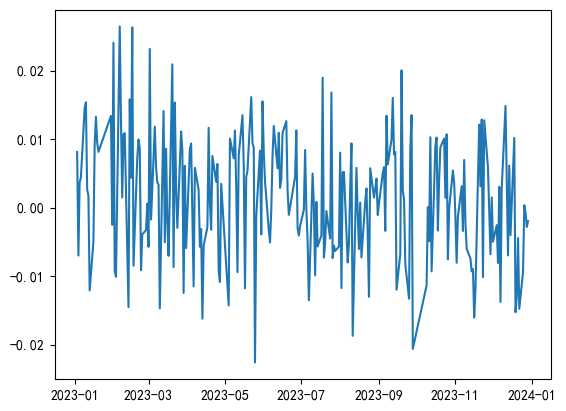

In [19]:
data['OI_skew_10'] = data['order_imbalance'].rolling(window=10).skew()
plt.plot(cal_ic('OI_skew_10'))
cal_ic('OI_skew_10').mean()

5.977074596901827e-05

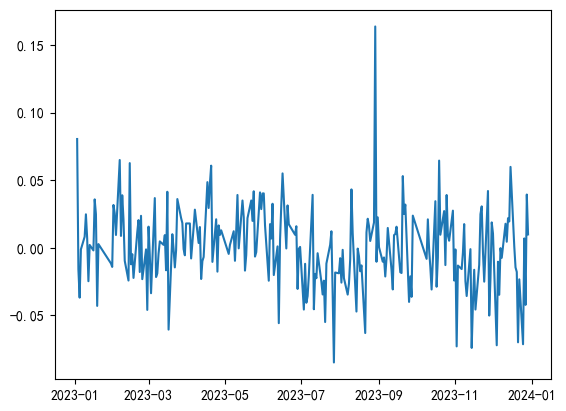

In [20]:
data['OI_skew_120'] = data['order_imbalance'].rolling(window=120).skew()
plt.plot(cal_ic('OI_skew_120'))
cal_ic('OI_skew_120').mean()

市场压力因子通过计算买卖盘价位差异来捕捉买卖双方的压力。这个因子可以揭示价格可能的移动方向。

- 市场压力：

$$
\text{market\_pressure} = \frac{\text{BidPrice1} \cdot \text{BidVolume1} - \text{AskPrice1} \cdot \text{AskVolume1}}{\text{BidPrice1} \cdot \text{BidVolume1} + \text{AskPrice1} \cdot \text{AskVolume1}}
$$

0.06338222312786054

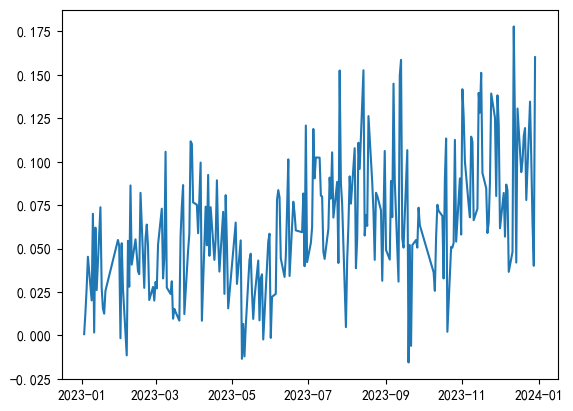

In [21]:
data['market_pressure'] = (data['BidPrice1']*data['BidVolume1']-data['AskPrice1']*data['AskVolume1'])/(data['BidPrice1']*data['BidVolume1']+data['AskPrice1']*data['AskVolume1'])
plt.plot(cal_ic('market_pressure'))
cal_ic('market_pressure').mean()

股票的交易成本是影响股票回报的重要因素之一，股票的交易成本越高，代表其流动性越差，因此未来有正向的流动性风险溢价。首先使用高频盘口数据，利用价差与股票中间价的比值构建流动性高频因子。ES、PRS使用“percent-cost”的衡量方式，代表执行交易所需的交易成本。

ES指标：根据股票i在时间t的收盘价和最优报价数据，构建有效价差（Effective Spread）

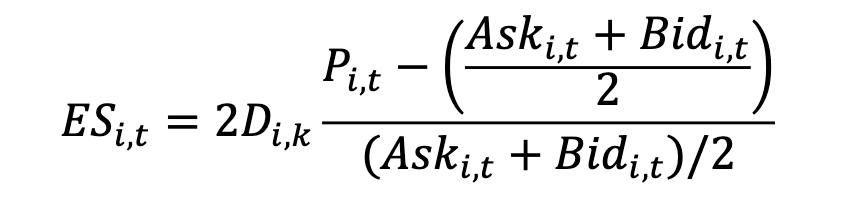

퐷푖,푘根据Lee & Ready（1991）的算法构建：如果当前收盘价高于（低于）最优买卖报价平均值，则认为是买（卖）单；当前收盘价等于最优买卖报价平均值时，如果收盘价高于（低于）上一笔价格，则认为是买（卖）单。

0.0009390548873405557

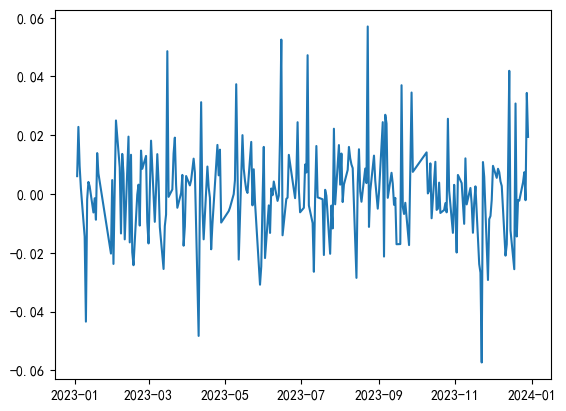

In [22]:
def calculate_direction(P_t, Ask_t, Bid_t):
    """
    根据成交价与最优报价中间价确定买卖方向.
    """
    mid_price = (Ask_t + Bid_t) / 2
    if P_t > mid_price:
        return 1  # 买单
    elif P_t < mid_price:
        return -1  # 卖单
    else:
        return 0  # 无法确定

def calculate_effective_spread(df):
    """
    计算有效价差因子 ES.
    """
    df['D_k'] = df.apply(lambda row: calculate_direction(row['LastPrice'], row['AskPrice1'], row['BidPrice1']), axis=1)
    df['mid_price_t'] = (df['AskPrice1'] + df['BidPrice1']) / 2
    df['ES'] = 2 * df['D_k'] * (df['LastPrice'] - df['mid_price_t']) / df['mid_price_t']
    return df['ES']

data['effective_spread'] = calculate_effective_spread(data)
plt.plot(cal_ic('effective_spread'))
cal_ic('effective_spread').mean()

- 多层次订单失衡因子（Order Flow Imbalance, OFI）

买盘变化量（ \Delta V^B_t ）：
- 如果买一价格下降（意味着卖方压低了买一价），则认为买一价上的委托单被撤销，买盘变化量设为 - 买一数量。
- 如果买一价格保持不变，计算买盘变化量为当前买一数量与上一时刻买一数量的差值。
- 如果买一价格上升，则认为市场对买盘需求较强，计算买盘变化量为当前买一数量。

卖盘变化量（ \Delta V^A_t ）：
- 如果卖一价格上升（意味着买方提高了卖一价），则认为卖一价上的委托单被撤销，卖盘变化量设为 - 卖一数量。
- 如果卖一价格保持不变，计算卖盘变化量为当前卖一数量与上一时刻卖一数量的差值。
- 如果卖一价格下降，则认为市场对卖盘需求较强，计算卖盘变化量为当前卖一数量。


在n时刻，卖一价为$P_n^A$，买一价为$P_n^B$，此时，中间价为$P_n$，且最中间的红蓝柱子分别表示卖一量和买一量。在 n+1 时刻，从卖价端的角度，原卖一量被取消，卖一价上涨至PA+1，中间价上涨至Pn+1。此时，卖价端的订单失衡为负向n时刻的卖一量，而从OFI_1因子总体来看，卖家端对价格的影响为正向n时刻的卖一量。而从买家端的角度，买一价不变，即p,=p，此时，买价端订单失衡为n+1时刻的买一量减去n时刻的买一量。

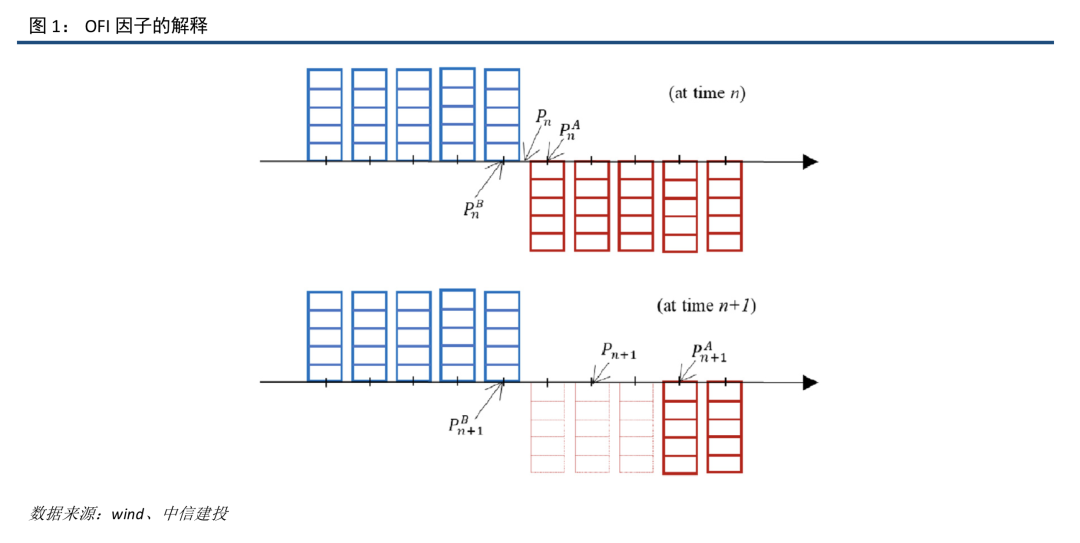

OFI 计算基于以下公式：

$$
\Delta V^B_t =
\begin{cases}
-V^B_{t-1} & \text{if } P^B_t < P^B_{t-1} \\
V^B_t - V^B_{t-1} & \text{if } P^B_t = P^B_{t-1} \\
V^B_t & \text{if } P^B_t > P^B_{t-1}
\end{cases}
$$

$$
\Delta V^A_t =
\begin{cases}
V^A_t & \text{if } P^A_t < P^A_{t-1} \\
V^A_t - V^A_{t-1} & \text{if } P^A_t = P^A_{t-1} \\
-V^A_{t-1} & \text{if } P^A_t > P^A_{t-1}
\end{cases}
$$

$$
OFI_t = \Delta V^B_t - \Delta V^A_t
$$

其中：

- $P^B_t$  和  $P^A_t$  分别为当前时刻的买一价和卖一价；
- $V^B_t$  和  $V^A_t$  分别为当前时刻的买一量和卖一量。

- 多层次订单失衡合成因子（MOFI）

MOFI 是对不同档位的  OFI  因子进行加总得到的：

$$
MOFI = \sum_{i=1}^{5} OFI^{(i)}
$$

- 带权重的多层次订单失衡因子（MOFI_Weight）

根据不同档位的信息权重，对  $OFI^{(i)}$  加权求和：

$$
MOFI\_Weight = \frac{\sum{i=1}^{5} w_i \times OFI^{(i)}t}{\sum{i=1}^{5} w_i}
$$

其中  $w_i = \frac{i}{5}$ ，即第一档权重最低，第五档权重最高。

- 订单斜率因子（Logquote Slope）

订单斜率因子衡量订单簿不同价格层级的买卖差异，公式为：

$$
\text{LogquoteSlope}_k = \frac{\log(A_k) - \log(B_k)}{\log(N^A_k) + \log(N^B_k)}
$$

其中：

- $A_k$  和  $B_k$  分别表示第  k  档的卖价和买价；
- $N^A_k$  和  $N^B_k$  分别表示第  k  档的卖量和买量。

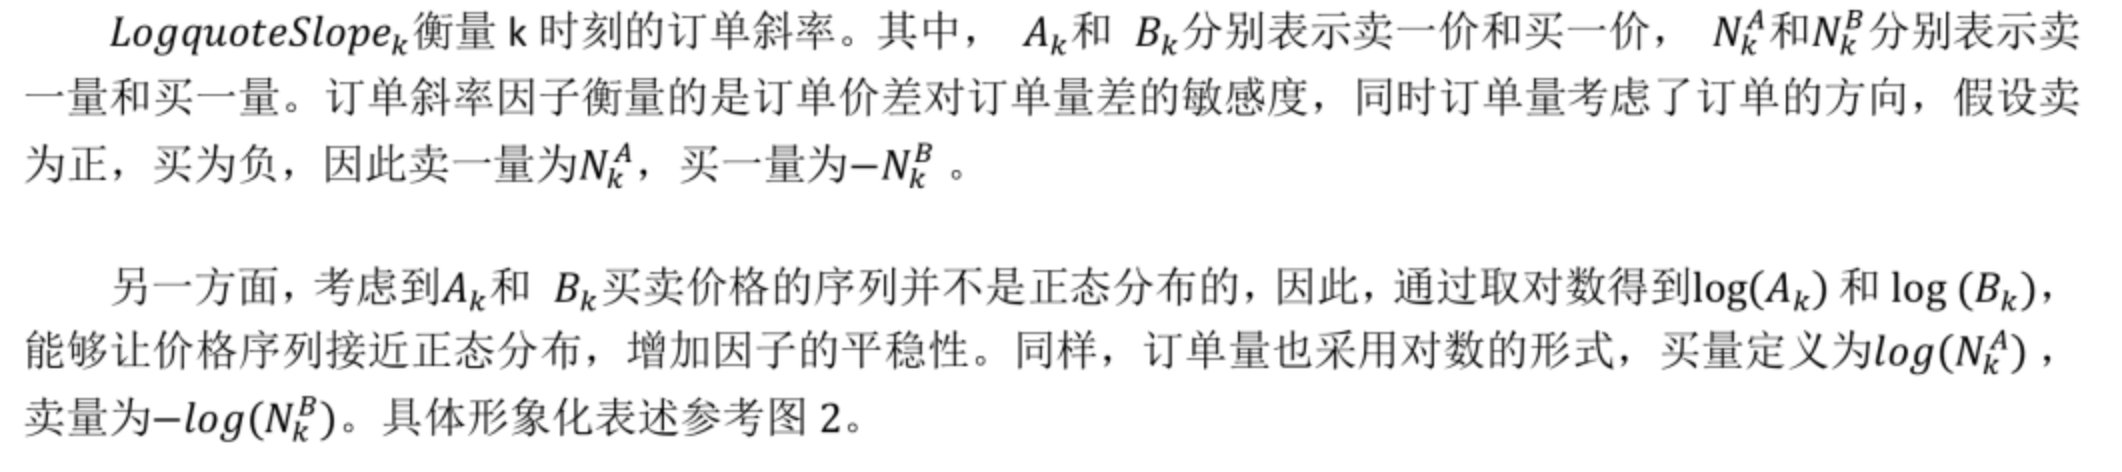

0.014838828990901618

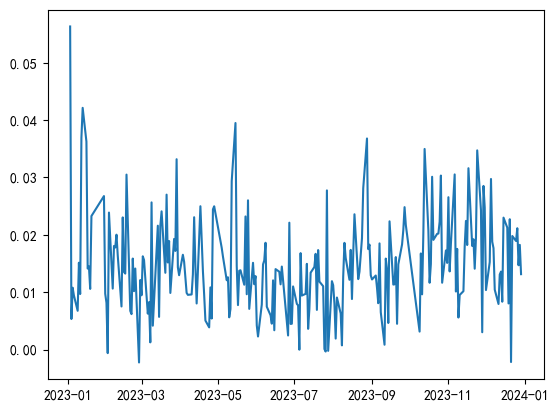

In [23]:
def calculate_ofi(df, bid_price, ask_price, bid_volume, ask_volume):
    # 计算买卖价和买卖量的变化
    delta_bid_vol = np.where(df[bid_price] < df[bid_price].shift(1), -df[bid_volume].shift(1),
                             np.where(df[bid_price] > df[bid_price].shift(1), df[bid_volume],
                                      df[bid_volume] - df[bid_volume].shift(1)))

    delta_ask_vol = np.where(df[ask_price] < df[ask_price].shift(1), df[ask_volume],
                             np.where(df[ask_price] > df[ask_price].shift(1), -df[ask_volume].shift(1),
                                      df[ask_volume] - df[ask_volume].shift(1)))
    # 计算 OFI
    ofi = delta_bid_vol - delta_ask_vol
    return ofi

# 计算不同档位的 OFI
data['OFI1'] = calculate_ofi(data, 'BidPrice1', 'AskPrice1', 'BidVolume1', 'AskVolume1')
plt.plot(cal_ic('OFI1'))
cal_ic('OFI1').mean()

In [24]:
data['OFI2'] = calculate_ofi(data, 'BidPrice2', 'AskPrice2', 'BidVolume2', 'AskVolume2')
print(cal_ic('OFI2').mean())
data['OFI3'] = calculate_ofi(data, 'BidPrice3', 'AskPrice3', 'BidVolume3', 'AskVolume3')
print(cal_ic('OFI3').mean())
data['OFI4'] = calculate_ofi(data, 'BidPrice4', 'AskPrice4', 'BidVolume4', 'AskVolume4')
print(cal_ic('OFI4').mean())
data['OFI5'] = calculate_ofi(data, 'BidPrice5', 'AskPrice5', 'BidVolume5', 'AskVolume5')
print(cal_ic('OFI5').mean())

-0.014910078115308893
-0.01626800127887822
-0.016079917796108782
-0.015940304785847435


-0.015896735663176818

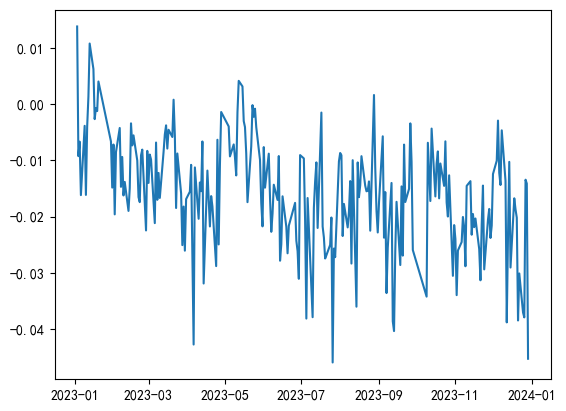

In [25]:
# 计算 MOFI（不同档位 OFI 的合成）
data['MOFI'] = data['OFI1']+data['OFI2']+data['OFI3']+data['OFI4']+data['OFI5']
plt.plot(cal_ic('MOFI'))
cal_ic('MOFI').mean()

SOIRi (i=1,2,3,4,5)这一组逐档订单失衡率因子，其中每个因子仅包含第i档的信息。最后，为了充分利用盘口各档数据信息，我们采用衰减加权的方法对SOIRi加权得到SOIR因子，根据对买卖压力的影响力的不同将不同档位赋予相应权重，赋予靠近交易价格档位更高的权重。

In [32]:
data['SOIR1'] = (data['BidVolume1']-data['AskVolume1'])/(data['BidVolume1']+data['AskVolume1'])
data['SOIR2'] = (data['BidVolume2']-data['AskVolume2'])/(data['BidVolume2']+data['AskVolume2'])
data['SOIR3'] = (data['BidVolume3']-data['AskVolume3'])/(data['BidVolume3']+data['AskVolume3'])
data['SOIR4'] = (data['BidVolume4']-data['AskVolume4'])/(data['BidVolume4']+data['AskVolume4'])
data['SOIR5'] = (data['BidVolume5']-data['AskVolume5'])/(data['BidVolume5']+data['AskVolume5'])

0.06338239454385476

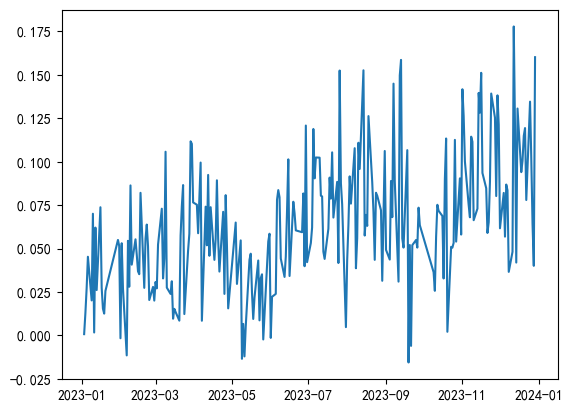

In [33]:
plt.plot(cal_ic('SOIR1'))
cal_ic('SOIR1').mean()

0.016041050602876094

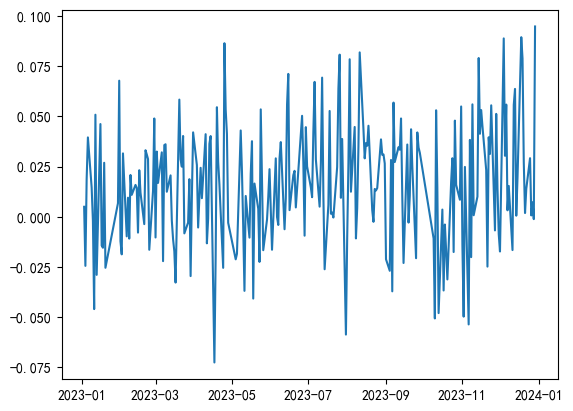

In [34]:
plt.plot(cal_ic('SOIR2'))
cal_ic('SOIR2').mean()

0.0458291050069546

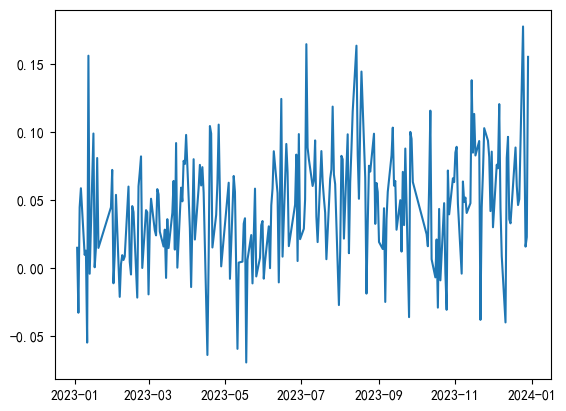

In [35]:
data['SOIR'] = data['SOIR1']+data['SOIR2']+data['SOIR3']+data['SOIR4']+data['SOIR5']
plt.plot(cal_ic('SOIR'))
cal_ic('SOIR').mean()

0.05768832903498322

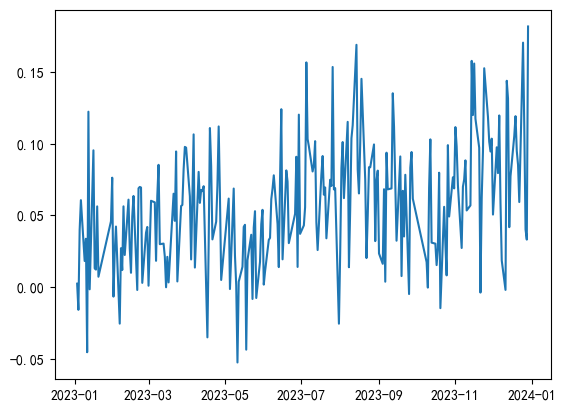

In [36]:
data['SOIR_weighted'] = 5*data['SOIR1']+4*data['SOIR2']+3*data['SOIR3']+2*data['SOIR4']+data['SOIR5']
plt.plot(cal_ic('SOIR_weighted'))
cal_ic('SOIR_weighted').mean()